In [1]:
import cv2 
import time
import numpy as np
from PIL import Image 
import math
import matplotlib
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt



In [2]:
import Vision as vis

besoin de prendre plusieurs frame pour éviter l'effet jaune

frame 0
frame 1
frame 2
frame 3
frame 4


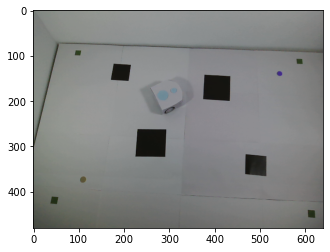

In [3]:
cap=cv2.VideoCapture(1,cv2.CAP_DSHOW)
for i in range (5):
    _, frame = cap.read()
    time.sleep(1)
    print("frame {}".format(i))

cap.release()
    
#frame=vis.img_calibration(frame)
    
plt.figure()
plt.imshow(frame)
plt.show()

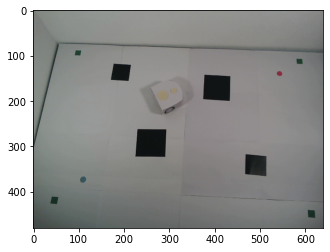

In [4]:
template = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(template)
plt.show()

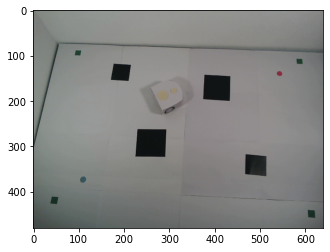

In [5]:
#blurring the picture
blurred = cv2.GaussianBlur(template, (7, 7), 0)
plt.figure()
plt.imshow(template)
plt.show()

## Configuration Mask Green et erode

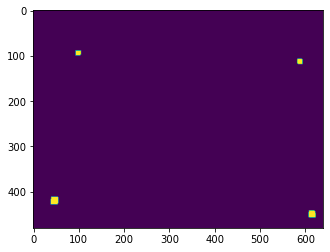

In [6]:
#testing green mask
green_lower=np.array([45,30,30])
green_upper=np.array([90,255,255])


img_hsv = cv2.cvtColor(blurred, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(img_hsv, green_lower, green_upper)
mask = cv2.erode(mask,None, iterations=4)
mask = cv2.dilate(mask,None, iterations=4)


plt.figure()
plt.imshow(mask)
plt.show()

## Configuration de area size

In [7]:
#Finding the contours

#very important: CHAIN_APPROX_NONE find all contours while simple only finds one
contours,_=cv2.findContours(mask, cv2.RETR_TREE,
                                cv2.CHAIN_APPROX_SIMPLE)
#trying to draw them
#img_cont=vis.plot_contours(mask, contours, 200, 4)

img_test=blurred.copy()
area_size=50
nb_sides=4
to_be_deleted=[]


#very important to loop backwards
print(len(contours))
initial_length=len(contours)
for i in range(len(contours)) :
    print("i ={}".format(i))
    backwards_i=initial_length-i-1
    print("back_i ={}".format(backwards_i))
    area = cv2.contourArea(contours[backwards_i])
    # Shortlisting the regions based on there area.
    if area < area_size: 
        print("this contour should be supressed {}".format(backwards_i))
        del contours[backwards_i]
 

print(len(contours))




4
i =0
back_i =3
i =1
back_i =2
i =2
back_i =1
i =3
back_i =0
4


4


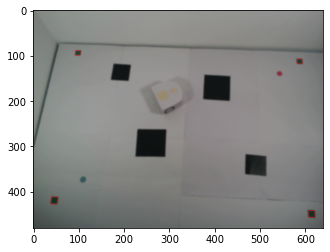

In [8]:
#plotting the resulting contours
cv2.drawContours(img_test, contours, -1, (255, 0, 0),1 )
        
cv2.imshow('contours on hsv mask', img_test)
print(len(contours))

plt.figure()
plt.imshow(img_test)
plt.show()

In [9]:
#find corners coord
corner_points = []
print(len(contours))
for i in range(len(contours)):
    if (cv2.contourArea(contours[i]) > area_size):
        mom = cv2.moments(contours[i])
        corner_points.append((int(mom['m10'] / mom['m00']), int(mom['m01'] / mom['m00']))) #centre des carrés

if len(corner_points) != 4:
    print("failure in identifying corners")

print(corner_points)
        

4
[(615, 448), (47, 419), (588, 112), (99, 93)]


corner x 615 y 448
corner x 47 y 419
corner x 588 y 112
corner x 99 y 93


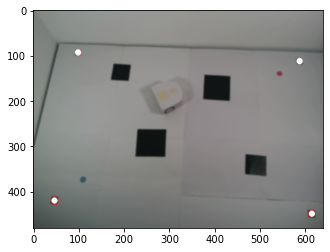

In [10]:
#plot the image with the center on it
# we iterate through each corner, 
# making a circle at each center of corner.
for center in corner_points:
    x, y = center[0], center[1]
    print(f'corner x {x} y {y}')
    cv2.circle(img_test, (x,y), 7, (255, 255, 255), -1)
    #cv2.circle(obsdetect, (x, y), 1, 255, 10)
    
plt.figure()
plt.imshow(img_test)
plt.show()

In [11]:
#ordering the points

#sorting points first by the 2nd the coordinate then 1st coordinate
pts=sorted(corner_points, key=lambda x: (int(x[1]), int(x[0]))) #topleft,topright,bottomleft,bottomright
#vérification du sorting et intervertit si il y a eu une erreur (est necessaire ??)
#top left x > top right x => erreur et intervertit
if pts[0][0] > pts[1][0]:
    pts[0], pts[1] = pts[1], pts[0]
if pts[2][0] > pts[3][0]:
    pts[2], pts[3] = pts[3], pts[2]

for pt in pts:
    x,y=pt[0],pt[1]
    print(f'corner x {x} y {y}')
    
print(pts)

corner_points=pts

corner x 99 y 93
corner x 588 y 112
corner x 47 y 419
corner x 615 y 448
[(99, 93), (588, 112), (47, 419), (615, 448)]


MaxWidth568
maxHeight337
dst[[  0.   0.]
 [567.   0.]
 [  0. 336.]
 [567. 336.]]
corner[[ 99.  93.]
 [588. 112.]
 [ 47. 419.]
 [615. 448.]]
Tranform[[ 1.23218471e+00  1.96544801e-01 -1.40264953e+02]
 [-4.85027639e-02  1.24830798e+00 -1.11290868e+02]
 [ 1.87941715e-05  5.19758966e-04  1.00000000e+00]]


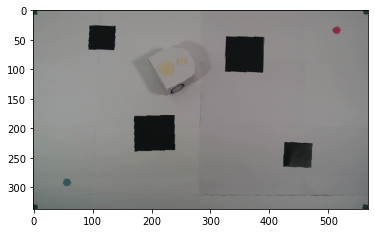

In [12]:
#transformation of the image

(tl, tr, bl, br) = corner_points

#computing width and height
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))
print("MaxWidth{}".format(maxWidth))

heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))
print("maxHeight{}".format(maxHeight))

dst = np.array([[0, 0],[maxWidth-1, 0],[0, maxHeight - 1],[maxWidth-1, maxHeight - 1]], dtype = "float32")
print("dst{}".format(dst))
#conversion needed corner points => np.array
corner_points=np.array(corner_points,dtype = "float32")
print("corner{}".format(corner_points))
#computing perspective transform matrix
M = cv2.getPerspectiveTransform(corner_points, dst)

print("Tranform{}".format(M))


final = cv2.warpPerspective(template, M, (maxWidth, maxHeight), cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
#cv2.imwrite('warpped.png',final)
plt.figure()
plt.imshow(final)
plt.show()

In [67]:
#imap = cv2.imread('env_final.jpeg')
template = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#blurring the picture
blurred = cv2.GaussianBlur(template, (7, 7), 0)
#testing green mask
green_lower=np.array([45,30,30])
green_upper=np.array([90,255,255])
iterations_erode=4
area_size=50


img_hsv = cv2.cvtColor(blurred, cv2.COLOR_RGB2HSV)
mask = cv2.inRange(img_hsv, green_lower, green_upper)
mask = cv2.erode(mask,None, iterations=iterations_erode)
mask = cv2.dilate(mask,None, iterations=iterations_erode)

#Finding the contours

#very important: CHAIN_APPROX_NONE find all contours while simple only finds one
contours,_=cv2.findContours(mask, cv2.RETR_TREE,
                                cv2.CHAIN_APPROX_SIMPLE)
#trying to draw them
#img_cont=vis.plot_contours(mask, contours, 200, 4)

img_test=blurred.copy()
area_size=50
nb_sides=4
to_be_deleted=[]


#very important to loop backwards
print(len(contours))
initial_length=len(contours)
for i in range(len(contours)) :
    print("i ={}".format(i))
    backwards_i=initial_length-i-1
    print("back_i ={}".format(backwards_i))
    area = cv2.contourArea(contours[backwards_i])
    # Shortlisting the regions based on there area.
    if area < area_size: 
        print("this contour should be supressed {}".format(backwards_i))
        del contours[backwards_i]
 
#find corners coord
corner_points = []
print(len(contours))
for i in range(len(contours)):
    if (cv2.contourArea(contours[i]) > area_size):
        mom = cv2.moments(contours[i])
        corner_points.append((int(mom['m10'] / mom['m00']), int(mom['m01'] / mom['m00']))) #centre des carrés

if len(corner_points) != 4:
    print("failure in identifying corners")

print(corner_points)

#ordering the points
corner_points=vis.order_points(corner_points)

for pt in corner_points:
    x,y=pt[0],pt[1]
    print(f'corner x {x} y {y}')
    
print(corner_points)

#transformation of the image

(tl, tr, bl, br) = corner_points

#computing width and height
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))
print("MaxWidth{}".format(maxWidth))

heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))
print("maxHeight{}".format(maxHeight))

dst = np.array([[0, 0],[maxWidth - 1, 0],[0, maxHeight - 1],[maxWidth - 1, maxHeight - 1]], dtype = "float32")
print("dst{}".format(dst))
#conversion needed corner points => np.array
corner_points=np.array(corner_points,dtype = "float32")
print("corner{}".format(corner_points))
#computing perspective transform matrix
M = cv2.getPerspectiveTransform(corner_points, dst)

print("Tranform{}".format(M))


final = cv2.warpPerspective(template, M, (maxWidth, maxHeight), cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
cv2.imwrite('warpped.png',final)


4
i =0
back_i =3
i =1
back_i =2
i =2
back_i =1
i =3
back_i =0
4
[(614, 447), (46, 419), (587, 111), (97, 93)]
corner x 97 y 93
corner x 587 y 111
corner x 46 y 419
corner x 614 y 447
[(97, 93), (587, 111), (46, 419), (614, 447)]
MaxWidth568
maxHeight337
dst[[  0.   0.]
 [567.   0.]
 [  0. 336.]
 [567. 336.]]
corner[[ 97.  93.]
 [587. 111.]
 [ 46. 419.]
 [614. 447.]]
Tranform[[ 1.23033406e+00  1.92475573e-01 -1.37242632e+02]
 [-4.57598961e-02  1.24568606e+00 -1.11410094e+02]
 [ 2.13237512e-05  5.12116648e-04  1.00000000e+00]]


True

frame 0
frame 1
frame 2
frame 3
frame 4


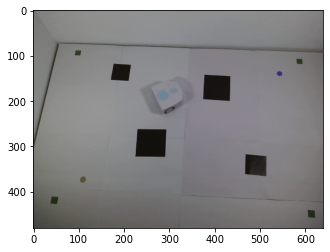

In [13]:
cap=cv2.VideoCapture(1,cv2.CAP_DSHOW)
for i in range (5):
    _, frame = cap.read()
    time.sleep(1)
    print("frame {}".format(i))

cap.release()
    
#frame=vis.img_calibration(frame)
    
plt.figure()
plt.imshow(frame)
plt.show()

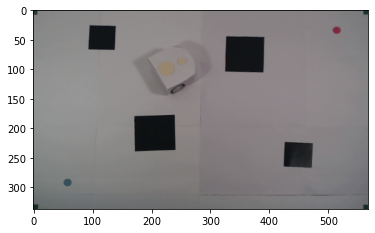

In [14]:
#img_final = cv2.imread(frame)
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
final=vis.img_calibration(img)
plt.figure()
plt.imshow(final)
plt.show()

useful other things

In [ ]:
def videoInit(): 
    # 1. Create an object. Zero for external camera
    video = cv2.VideoCapture(0)
    return video

In [ ]:
def takePicture(video): 
    check, frame = video.read()
    
    #print(frame) 
    
    return frame

In [ ]:
img = takePicture(video)
cv2.imwrite('map.png', img)

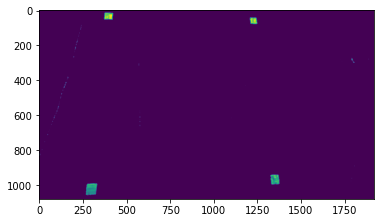

In [86]:
imgRGB = cv2.cvtColor(HSV_blur, cv2.COLOR_HSV2RGB)
imgray = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2GRAY)
plt.imshow(imgray)

In [87]:
imgRGB = cv2.cvtColor(output_hsv, cv2.COLOR_HSV2RGB)
imgray = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2GRAY)
ret, thresh = cv2.threshold(imgray, 110, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(contours)

[array([[[328, 992]]], dtype=int32), array([[[318, 992]]], dtype=int32), array([[[310, 992]],

       [[315, 992]]], dtype=int32), array([[[308, 992]]], dtype=int32), array([[[306, 992]]], dtype=int32), array([[[304, 992]]], dtype=int32), array([[[1372,  945]]], dtype=int32), array([[[578, 627]]], dtype=int32), array([[[578, 614]]], dtype=int32), array([[[578, 612]]], dtype=int32), array([[[578, 610]]], dtype=int32), array([[[578, 608]]], dtype=int32), array([[[578, 587]]], dtype=int32), array([[[154, 413]]], dtype=int32), array([[[1804,  298]],

       [[1805,  299]],

       [[1806,  298]],

       [[1805,  299]]], dtype=int32), array([[[1247,   58]],

       [[1247,   60]]], dtype=int32), array([[[1246,   51]]], dtype=int32), array([[[421,  50]],

       [[421,  52]]], dtype=int32), array([[[1245,   47]]], dtype=int32), array([[[421,  44]]], dtype=int32), array([[[374,  44]]], dtype=int32), array([[[374,  42]]], dtype=int32), array([[[374,  40]]], dtype=int32), array([[[423,  28]]],

In [4]:
img = imap.copy()
for cnt in contours :
    area = cv2.contourArea(cnt)
   
    # Shortlisting the regions based on there area.
    if area > 2: 
        print('a')
        approx = cv2.approxPolyDP(cnt, 
                                  0.009 * cv2.arcLength(cnt, True), True)
        print(approx)
   
        # Checking if the no. of sides of the selected region is 7.
        if(len(approx) == 4): 
            cv2.drawContours(img, [approx], 0, (0, 0, 255), 5)
        
plt.imshow(img)

NameError: name 'contours' is not defined

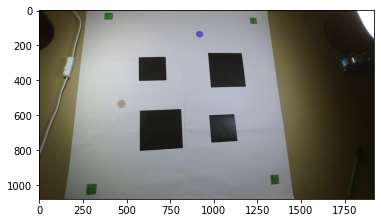

In [7]:
img = cv2.imread('map.png')

cimg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
cimg = cv2.medianBlur(cimg,5)
circles = cv2.HoughCircles(cimg,cv2.HOUGH_GRADIENT,1,20,
                            param1=50,param2=30,minRadius=0,maxRadius=150)
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
plt.imshow(img)

In [26]:
green_lower=np.array([30,50,50])
green_upper=np.array([80,255,255])

red_lower=np.array([150,50,50])
red_upper=np.array([200,255,255])

def order_points(pts):
    """
    # initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect
    """
     #sorting points first by the 2nd the coordinate then 1st coordinate
    pts=sorted(pts, key=lambda x: (int(x[1]), int(x[0]))) #topleft,topright,bottomleft,bottomright
    #vérification du sorting et intervertit si il y a eu une erreur
    #top left x > top right x => erreur et intervertit
    if pts[0][0] > pts[1][0]:
        pts[0], pts[1] = pts[1], pts[0]
    if pts[2][0] > pts[3][0]:
        pts[2], pts[3] = pts[3], pts[2]
    return pts


def four_point_transform(image, ordered_pts):	# obtain a consistent order of the points and unpack them
	# individually
	(tl, tr, br, bl) = ordered_pts
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(ordered_pts, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped


def img_calibration(img):
    #input img doit etre en rgb
    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    #applique flou gaussien pour que les contours soit moins durs
    HSV_blur = cv2.GaussianBlur(HSV, (7, 7), 0)
    #a voir si on utilise une autre couleur
    green_mask=cv2.inRange(HSV_blur,green_lower,green_upper)
    #green_mask[70:350,:]=0 #remove the yellow which is similar to green corners
    #green_mask[:,100:500]=0 #remove the yellow which is similar to green corners
    #maskedimg = img.copy()
    #maskedimg[np.where(green_mask==0)] = 0
    
    # Identifier les coins et leurs coordonnées
    #trouve les contours des coins
    contours, hierarchy = cv2.findContours(green_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
    corner_points = []
    for i in range(len(contours)):
        if (cv2.contourArea(contours[i]) > 200):
            mom = cv2.moments(contours[i])
            corner_points.append((int(mom['m10'] / mom['m00']), int(mom['m01'] / mom['m00']))) #centre des carrés
       

    if len(corner_points) != 4:
        print("failure in identifying corners")
        print(corner_points)
    corner_points=order_points(corner_points)
    #warpedimg=four_point_transform(img,corner_points)
    # Showing the image along with outlined arrow.
    #cv2.imshow('image2', img2) 
    #cv2.imwrite('lignes_red.png', img2)
    for i in contours:
        approx = cv2.approxPolyDP(i,0.009 * cv2.arcLength(i, True), True)
        if(len(approx) == 4): 
            cv2.drawContours(img, [approx], 0, (0, 0, 255), 5)
        
    plt.imshow(img)
    return img



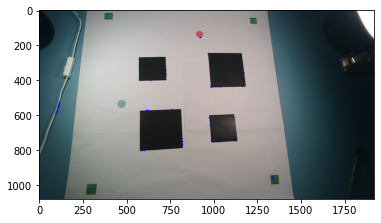

In [27]:
img_wraped = img_calibration(template)